# Summary
- Setup code
- Abstract
- Introduction and Objectives
- Methods
- Results and Discussion
- Conclusion

## Some scaffolding Code

### Importing the libraries

In [27]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import date
import time
import matplotlib.dates as mdates

def prettify(plt):
    plt.xticks(rotation=-30, alpha=0.5)
    plt.ylabel('In Millions')
    plt.grid()
    plt.legend()
    plt.show()


### Extracting the data from the file

In [28]:
# Importing data 
cols = ['dt_referencia', 'confirmados', 'recuperados', 'obitos']

df = pd.read_csv('./PE-data.csv', usecols=cols)
df.filter


initial_date = date(2020, 7, 1)
end_date = date(2021, 10, 31)
forecast_date = date(2022, 2, 28)
unix_inital_date = time.mktime(initial_date.timetuple())
unix_end_date = time.mktime(end_date.timetuple())


datetime_series = pd.to_datetime(df['dt_referencia'])

segs_per_d = 24 * 60 * 60

datetime_index = pd.DatetimeIndex(datetime_series.values)

df=df.set_index(datetime_index)
print(type(datetime_index))

df.drop('dt_referencia',axis=1,inplace=True)

df = df.loc['2020-07-01':'2021-10-31']

real_total_pop = 9.278E6

n_days = (end_date - initial_date).days
n_days_forecast = (forecast_date - initial_date).days
# forècaz 28/02/2022

t = np.array(list(range(0, n_days+1)))
r = pd.date_range(start=initial_date, end=end_date)

tf = np.array(list(range(0, n_days_forecast+1)))
rf = pd.date_range(start=initial_date, end=forecast_date)
df

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,confirmados,obitos,recuperados
2020-07-01,61119,4968,41925
2020-07-02,62362,5068,42456
2020-07-03,63457,5116,44314
2020-07-04,65129,5143,44568
2020-07-05,65642,5163,46417
...,...,...,...
2021-10-27,630520,19990,568818
2021-10-28,630980,20001,569115
2021-10-29,631632,20007,569986
2021-10-30,631892,20018,570246


### Some helper functions

In [29]:
def get_vaccines():
    cols = ['date', 'state', 'vaccinated', 'vaccinated_second']
    df = pd.read_csv('./cases-brazil-states.csv', usecols=cols)
    df.filter

    datetime_series = pd.to_datetime(df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)

    df=df.set_index(datetime_index)

    df = df.loc[df['state'] == 'PE']
    df = df.loc['2020-07-01':'2021-10-31']

    return df

data = get_vaccines()

In [30]:
def plot_model(model, initial, zoom=False, simple=False):
    solution = odeint(model, initial, tf)

    idx_off = 0
    if simple:
        idx_off = -1

    S = solution[:, 0]
    E = []
    if not simple:
        E = solution[:, 1]
    I = solution[:, 2 + idx_off]
    R = solution[:, 3 + idx_off]
    V = []
    if not simple:
        V = solution[:, 4]

    real_V = get_vaccines()['vaccinated']

    if not zoom:
        plt.plot(rf, S, label="S", color="darkblue", linestyle="dotted")
        if not simple:
            plt.plot(rf, E, label="E", color="darkgreen", linestyle="dotted")
    plt.plot(rf, I, label="I", color="red", linestyle="dashed")
    plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
    plt.plot(rf, R, label="R", color="black", linestyle="dashed")
    plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")

    if not zoom and not simple:
        plt.plot(rf, V, label="V", color="blue", linestyle="dashed")
        plt.plot(real_V, color="blue", label="Real V")

    prettify(plt)

In [31]:
def SEIRV_builder(N=real_total_pop,  beta=0.074, mu=0.0028, a=1/14, zeta=None, gamma=1/18, vaccine_start=250, vaccine_rate=0.005):

    beta /= N

    def SEIRV(u, t):


        S = u[0]
        E = u[1]
        I = u[2]
        R = u[3]
        V = u[4]

        # Gamma is  Infecctious period https://www.nature.com/articles/s41467-020-20568-4
        # Alpha is  Time that a person takes to become infecctious
        zeta = vaccine_rate * np.heaviside(t-vaccine_start, 0)
        return [
            mu*N - mu*S - beta*S*I -zeta*S,
            beta*S*I - (mu + a) * E,
            a*E - (gamma + mu) * I,
            gamma*I - mu*R,
            zeta*S - mu*V
        ]
    return SEIRV


# Abstract
This is a numerical analysis about COVID-19 in Pernambuco. It's going to model the behaviour of the pandemic between 01/07/2020 and 31/10/2021 and forecast the evolution of the pandemic up to 28/02/2022. We wil use the SEIRV model which is an extension of the SEIR model that also takes into account the number of vaccinations and it's effect on the epidemic outcomes.


# Introduction and Objectives
The COVID-19 pandemic has changed an taken the lives of many people. Being able to forecast and test the outcome of different measures to contain the disease is fundamental to its erradication and control.
This is why a Numerical Model is so important in this scenario because it's a transparent sandbox where it's possible to test many different measures and alternative realities.

We expect our model to be able to fit the historical data in Pernambuco about the COVID-19 pandemic and then create a _reasonable_ forecast. We also plan to tweak different parameters and see what would happen in those scenarios such as varying $\beta$ (the effective contamination) to model the use of masks.


# Methods
**In order for us to familiarize with the data in hands**, we decided to first model the pandemic with the basic $SIR$ model and compare the graph of this model to the actual historical data and also tune the $\beta$ and $\gamma$ parameters. We'll use real data about Pernambuco's population for the $S$, $I$, $R$ values. 


The $SIR$ model:
$$
\begin{align*}
\frac{dS}{dt} &= -\beta SI  \\
\frac{dI}{dt} &= \beta SI - \gamma I \\
\frac{dR}{dt} &= \gamma I \\
\end{align*}
$$


The $SIR$ is a compartmentalized model about an epidemic, each person can be in only three distinct discrete states:
- $S$: Succeptible
- $I$: Infectious
- $R$: Recovered


The differential equations model the flow of people from one state to the other, it's also important to note that in the most basic form, the $SIR$ model has a fixed total population, so
$$
\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0
$$

which means that the total population won't change, note that this don't means that people don't die, as the recovered can be seen as dead + recovered people.

Which in `python` code is as follows:

### The $SIR$ model

In [32]:
def SIR(u, t):

    N = real_total_pop

    S = u[0]
    I = u[1]
    R = u[2]

    beta = 0.08 / N
    gamma = 0.0785

    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]


The `beta` and `gamma` parameters were tuned by hand to match the real data.


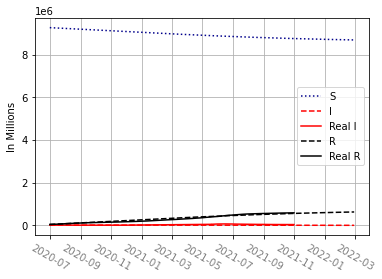

In [33]:
model_pop = real_total_pop 
model_infected = (61119 - (41925 + 4968)) / real_total_pop
model_recovered = (41925 + 4968) / real_total_pop
u = [model_pop - (model_pop * model_infected), model_pop * model_infected, model_pop * model_recovered]

plot_model(SIR, u, simple=True)

Now plotting just the $I$ and the $R$ for better detail

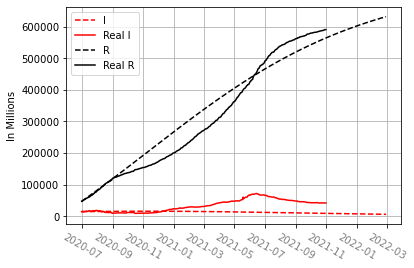

In [34]:

plot_model(SIR, u, zoom=True, simple=True)

### $SEIR$ model

Although the simplified SIR model is capable enough of giving a rough estimative of the epidemic outcomes, there are a number of variables we're not taking into account that have great impact in how the system performs. Two of such variables are the birth and death rates of the population, that act as indicators of how much new suceptible people are entering the system and how much already infectious people are ceasing to be a part of the sample space.

In order to accomodate these new parameters, which can be refered to as _vital dynamics_ (people being born and dying of normal causes), we've implemented a more sophisticaded model called $SEIR$, that uses a constant rate of birth and death and introduces a new state in which a person can be:
- _Exposed_, which they can die or become infected.

We'll also assume that the birth rate and death rate are the same. But this doesn't make the vital dynamics useless because it feeds constantly with fresh new Succeptible people.

The $SEIR$ model:

$$
\begin{align*}



\frac{dS}{dt} &= \mu N - \mu S - \frac{\beta IS}{N} \\ \\
\frac{dE}{dt} &= \frac{\beta IS}{N} - (\mu + \alpha)E \\ \\
\frac{dI}{dt} &= \alpha E - (\gamma + \mu) I \\ \\
\frac{dR}{dt} &= \gamma I - \mu R \\ \\

\end{align*}
$$

From the $SIR$ to the new $SEIR$ model we've added a new state $E$ (exposed), and in the model this means that we added a new equation that now the $\frac{dS}{dt}$ flows to it.

The vital dynamics are modelled by the $\mu$ constant, which takes people indiscriminately from every compartment and adds the same ammount of people to the $S$ state.

*To work with big numbers that resemble real data, we need to normalize the $\beta I S$ multiplication*

### Final $SEIRV$ model

The $SEIR$ model brings the simulation closer to the real world but still doesn't take into account that which has been proven to be the most impactful positive agent in the improvement of the pandemic situation: the vaccines. 

This very important parameter (the vaccination rate) helps us understand the importance not only of the existence of the vaccines, but also the extent to which they're are applied and, thus, the scale of people that are immune to the disease.

So, to further develop the SEIR model and bring it closer to real-world scenarios, we decided to extend it with a variable for vaccinations, creating the SEIRV model:

We added $V$ which is the vaccinated population, and its variation is modeled by $\frac{dV}{dt}$, dependent on the total number of succeptible people being vaccinated.

With this adition, we aim is to simulate how different vaccination rates would affect the outcomes of infected and deceased people, for example:
- how much lower the number of deceased people would be today if the vaccination began earlier
- how different are the outcomes of infection with and without vaccines
- how different vaccination schemes would affect the total outcomes of the pandemic
- how the spike of infections due to holidays festivities would be different with and without vaccines

The $SEIRV$ model:

$$
\begin{align*}



\frac{dS}{dt} &= \mu N - \mu S - \frac{\beta IS}{N} -\zeta S \\ \\
\frac{dE}{dt} &= \frac{\beta IS}{N} - (\mu + \alpha)E \\ \\
\frac{dI}{dt} &= \alpha E - (\gamma + \mu) I \\ \\
\frac{dR}{dt} &= \gamma I - \mu R \\ \\
\frac{dV}{dt} &= \zeta S - \mu V


\end{align*}
$$

From the $SEIR$ to the $SEIRV$ we've added a new state ($V$) which its input is the rate of vaccination $\zeta$ and the total succeptible population.

## The SEIRV model parameters and constants are as follows:

### Parameters
- $S$ $\to$ people susceptible to infection
- $E$ $\to$ people exposed to infection
- $I$ $\to$ already infected people
- $R$ $\to$ recovered people 
- $V$ $\to$ vaccinated people

### Constants
- $\alpha$ $\to$ incubation time (how much time until a infected person becomes infectious)
- $\mu$   $\to$ birth/death rate (they're the same)
- $\beta$ $\to$ transmission rate (doesn't spread the disease)
- $\zeta$ $\to$ vaccination rate

The transmission rate $\beta$ is responsable for turning a portion of the population from susceptible to the state of exposed, which doesn't yet spread the virus. With time ($\alpha$), people who were exposed to the virus become infectious and eventually die or become recovered. The vaccine, represented by $\zeta$ immediatly turns people from susceptible to vaccinated. 

This translates to this Python code:

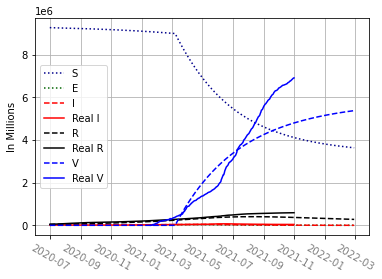

In [35]:
u = [model_pop - (model_pop * model_infected),0, model_pop * model_infected,model_pop * model_recovered, 0]
plot_model(SEIRV_builder(), u)

The numerical model is found inside the `SEIRV_builder()` function, which is defined on the top of this notebook. In the real world the vaccination only started about halfway in the analyzed timeframe, so to model this we've replaced $\zeta$ as the vaccination rate by $\zeta H(t-T)$, which also makes it possible for us to tweak the starting date of the vaccination by just changing the $T$ variable.

## Test Scenario: How different are the outcomes of inffection with and without vaccines

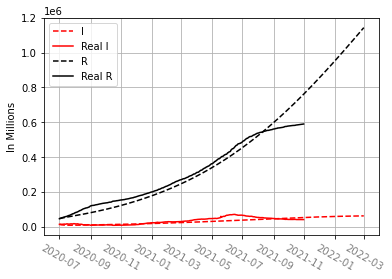

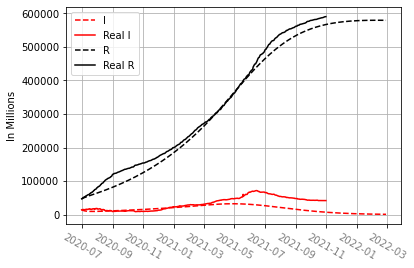

In [43]:
plot_model(SEIRV_builder(beta=0.065, vaccine_rate=0, mu=0.0001), u, zoom=True)
plot_model(SEIRV_builder(beta=0.066, mu=0.0001, vaccine_rate=0.003), u, zoom=True)

## Test Scenario: how much lower the number of deceased people would be today if the vaccination began earlier
 

This model also forecasts the direction which the pandemic is going up to 28/02/2022.

The difference in the latter days can be explained by the reduction of $\beta$ with the start of the vaccination of the population and quarantines imposed by Pernambuco's government.

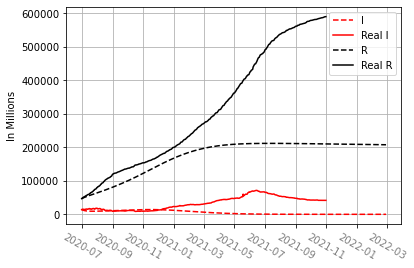

In [37]:
plot_model(SEIRV_builder(beta=0.065, vaccine_start=100, mu=0.0001), u, zoom=True)

# Results and Discussion
Since our data is limited, we can create forecasts about the future of the system by simulating the trends with the help of the created model. In the examples above, we've shown forecasts  that span about 25% the time domain of the real-world data, and gives us a prediction upon wich we can get the insights needed to better understand the practical effects of different situations and it's outcomes.

The $SEIRV$ model with populational dynamics (in some configuration of parameters) can present an oscilatory behaviour similiar to a second order differential equation with damping, which is very interesting.


In each of the above graphs we've seen for (for example) no vaccination could affect the pandemic, and it looks like an uncontrolled exponential growth (in actuality is the first half of a logistic curve). We've also seen that if the vaccination began earlier it would spare many lives.


We've seen that only using the $SEIR$ model we couldn't achieve the deceleration of the spread of the disease that is shown in the real data. But when we switched to the $SEIRV$ it was possible to do so, by doing an delayed vaccination (which matches the start of the vaccination in the real world). This result shows that there's a correlation between the vaccination and the reduction in cases.

The parameters that we used for the model were estimated and for real world usage it require better methods of estimation, i.e.: some constants such as $\mu$ can be modelled by real world data, but our model does not take that into account.

# Conclusion
In this project we saw how diffential equations can be really useful in the modeling process of dynamical systems. It was also really rewarding to tweak the model and understand every bit of it's inner workings and still be surprised by the solutions presented.

One thing that we realized is that when we modelled the vaccination, the outcomes of our model were very different and actually more easy to control, as we had some sort of *drain* which we could steadly remove *succeptible* people. This shows that the varibles that are chosen for the model are very important and that this *leverage* created in the model which we were able to better control the outcome of the pandemic can also reflext in the real world as a real *leverage* that can save many lives.

We think that differential models are a really valuable tool is this field, but it's easy to see many different applications as well. With a good enough model (specially with the correct variation of $\beta$) it should be possible to model the whole timeframe of the pandemic which proves an invaluable tool to policy makers and researchers.